### MCMC (Markov Chain Monte Carlo) techniques for sampling from a distribution
Typically, sampling from any distribution other than a normal or uniform is hard using simple np.random. As simple a distribution as a beta distribution cannot be sampled from using simple numpy. How can we sample from such distributions or from distributions which might not necessarily have closed form solutions, as is the case with most posterior distributions arising during Bayesian Data Analysis

This is mostly a recollection of the time I took STAT 220 (Bayesian Data Analysis) and followed the book by Gelman (pdf in folder). Chapter 11.

This [Medium post](https://towardsdatascience.com/mcmc-intuition-for-everyone-5ae79fff22b1) gives a good intuition for why we use a Markov Chain simulation method. TLDR: we are looking to converge to the stationary distribution of a Markov Chain. Why? Stationary distributions are the converged distribution that do not change under further transformation

Three algorithms are described:
* Metropolis algorithm
* Metropolis-Hastings algorithm
* Gibbs sampling

#### Gibbs Sampling
When we have to sample from a multivariate distribution, the idea of Gibbs sampling is to sample from the conditional distribution each. For example, let's try to sample from the multivariate normal, defined by

\begin{equation}
\begin{pmatrix}\theta_{1}\\
\theta_{2}\\
\end{pmatrix} \sim N\begin{pmatrix}\begin{pmatrix}y_{1}\\
y_{2}\\
\end{pmatrix}, \begin{pmatrix}1, \rho\\
\rho, 1\\
\end{pmatrix}\end{pmatrix}
\end{equation}

The conditional distributions are defined as:

$$p(\theta_1|\theta_2,y1,y2) = N(y_1 + \rho(\theta_2-y_2), 1-\rho^2)$$ and
$$p(\theta_2|\theta_1,y1,y2) = N(y_2 + \rho(\theta_1-y_1), 1-\rho^2)$$

How??? Later...

But then instead of sampling from a multivariate gaussian, we can sample from the conditional distributions for each $\theta$. **Note that sampling at each t should be done with respect to the most updated parameter for each parameter**

In [39]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pdb

In [125]:
def Gibbs(y1,y2,rho,N):
    theta1,theta2 = [0],[0]
    for i in range(1,N):
        theta1.append(np.random.normal(y1+rho*(theta2[i-1]-y2), 1-rho**2,1)[0]);
        theta2.append(np.random.normal(y2+rho*(theta1[i]-y1), 1-rho**2,1)[0]);
    return theta1, theta2

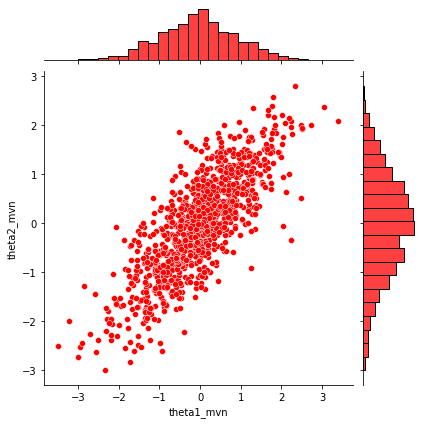

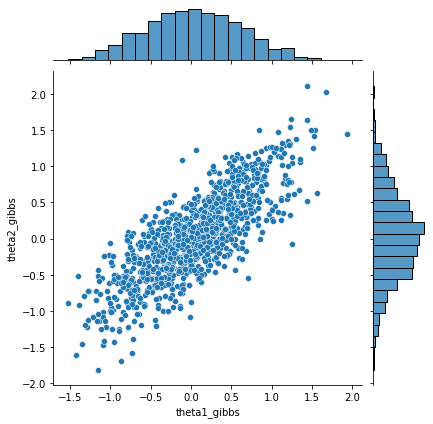

In [126]:
y1,y2=0,0; rho=0.8;
N=1000;
theta1, theta2=np.random.multivariate_normal([0,0],[[1, rho],[rho, 1]], N).T

df = pd.DataFrame(np.vstack((theta1, theta2)).T, columns=['theta1_mvn', 'theta2_mvn'])
df['theta1_gibbs'], df['theta2_gibbs'] = Gibbs(y1,y2,rho,N)
sns.jointplot(data=df,x='theta1_mvn',y='theta2_mvn',color='red')
sns.jointplot(data=df,x='theta1_gibbs',y='theta2_gibbs')

#### Metropolis algorithm
The Metropolis algorithm uses the ration of probabilities at the next sampled point to the current point to determine whether or not it should accept that point in the sample. The best analogy I've read is the analogy about jumping around on a rough terrain with hills and troughs. Imagine the terrain to be a probability distribution, and one wants to spend time on the terrain proportional to the height of the point. That is, if a point is too high, one wants to spend the most of the time on there. 

With this analogy, it's clear that it is not the absolute height of the hill but rather the ratio of that hill with the current point. So the idea of Metropolis is to randomly pick a new point (random with conditions), and then decide whether to go there or not based on how much more/less likely it is compared to the current point

Algorithmically, the following steps are involved:
* Pick a jumping or proposal distribution $J(\theta^*|\theta^{t-1})$. This jumping distribution must be symmetric (but not for Metropolis-Hastings), ie, $J(\theta_a|\theta_b) = J(\theta_b|\theta_a)$. Then sample a proposal $\theta^*$
* Calculate the ratio of the densities, $r = \frac{p(\theta^*|y)}{p(\theta^{t-1}|y)}$
* Set $\theta^t = \theta^* $ with probability min(r,1) or $\theta^{t-1}$ otherwise

Let's apply this to the same case of sampling for the bivariate normal with a normal jumping distribution with mean ($\theta^{t-1}$) and std (0.2). Why is this not working?

**Why does this algorithm work?**
Proof is on page 279 of the Gelman book. In short, the resultant distribution is a stationary distribution

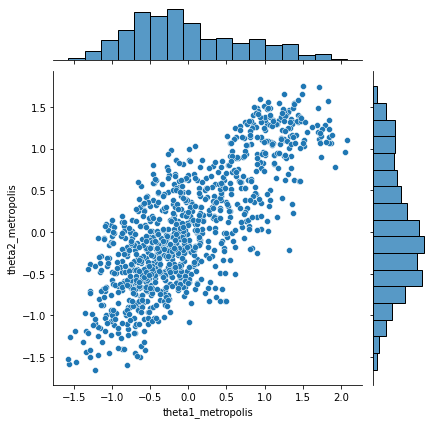

In [136]:
def Metropolis_with_Normal(std,N,rho=rho):
    i=0; theta=[[1,0]]
    while(i<N-1):
#         pdb.set_trace()
        theta_star1 = np.random.normal(theta[i][0],std)
        theta_star2 = np.random.normal(theta[i][1],std)
        
#         r = stats.norm.pdf(theta_star1,0,1)*stats.norm.pdf(theta_star2,0,1)/(stats.norm.pdf(theta[i-1][0],0,1)*stats.norm.pdf(theta[i-1][1],0,1))
        var1 = stats.multivariate_normal([0,0],[[1,rho],[rho,1]]);
        r=var1.pdf([theta_star1, theta_star2])/var1.pdf(theta[i-1])
        unif = np.random.uniform(0,1);
        if unif < np.min((r,1)):
            theta.append([theta_star1, theta_star2])
            i+=1;
#             print(i)
    return theta
theta = Metropolis_with_Normal(0.2,N*4);
df['theta1_metropolis'] = np.array(theta)[3*N:,0]
df['theta2_metropolis'] = np.array(theta)[3*N:,1]
sns.jointplot(data=df,x='theta1_metropolis',y='theta2_metropolis')
        

The Gibbs sampling algorithm is a special case of the Metropolis algorithm with 100% acceptance rate. Pro of Gibbs vs Metropolis is that the convergence is faster, but the con is that one needs to know the closed form of the conditional distribution which can often be hard to find

#### How does one be sure that we have converged?
Well, one can never be sure. But one can be confident by taking the following steps:
* Start with multiple start points and check that they converge to similar distribution
* We must diagnose convergence by using two metrics for each starting point:
    - Mixing: Do the two sequences have the same distribution
    - Stationarity: Do the two sequences have low within-sequence error in the recent time
    A very good visualization is shown is on page 283 of the Gelman book
    